## INTRODUCTION
We have been given census data about attributes of US citizens (occupation, education, gender, race). With organizations working to ensure equal pay, we want to build a model to see how accurately we can classify low income from high income citizens. Building this model will allow us to understand which attributes contribute to affluency and how we can improve policies in the US.

The two basic business problmes that we have to answer from our analysis are:-
   1. Does an individual make more than 50k income or not?
   2. What are the most important features that help to define the salary of an individual ?

#### Importing Required Libraries

In [130]:
import numpy as np
from numpy import nan
import pandas as pd
import shap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from pylab import rcParams
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

shap.initjs()

#### Load the dataset into a dataframe using a Pandas

In [36]:
data=pd.read_csv('adult-all.csv')

#### Checking the columns present in the dataframe and interpreting what they represent

In [37]:
data.columns

Index(['39', 'State-gov', '77516', 'Bachelors', '13', 'Never-married',
       'Adm-clerical', 'Not-in-family', 'White', 'Male', '2174', '0', '40',
       'United-States', '<=50K'],
      dtype='object')

This looks like that the data that we have do not have any feature names, thats why the data.columns is returing the first row.
We will have to fix this and add column names to this dataframe.
I will use the data descroption file provided in the module to add the column names to our dataframe

In [38]:
data.columns=['age','workclass','fnlwgt','education','education-num','martial_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','salary']

#### Now that we have our dataset, let us check what types of values it has and what do they represent.

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48841 entries, 0 to 48840
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48841 non-null  int64 
 1   workclass       48841 non-null  object
 2   fnlwgt          48841 non-null  int64 
 3   education       48841 non-null  object
 4   education-num   48841 non-null  int64 
 5   martial_status  48841 non-null  object
 6   occupation      48841 non-null  object
 7   relationship    48841 non-null  object
 8   race            48841 non-null  object
 9   sex             48841 non-null  object
 10  capital_gain    48841 non-null  int64 
 11  capital_loss    48841 non-null  int64 
 12  hours_per_week  48841 non-null  int64 
 13  native_country  48841 non-null  object
 14  salary          48841 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [40]:
# Total number of records
totalRecords = data.shape[0]

# Total number of features
totalFeatures = data.shape[1]

# Number of records where individual's income is more than $50,000
salaryGreaterThan50K = data[data['salary'] == '<=50K'].shape[0]

# Number of records where individual's income is at most $50,000
salaryLessThanEqualTo50K = data[data['salary'] == '>50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
percentDifference =  (salaryGreaterThan50K / totalRecords) * 100

# Print the results
print("Total number of records: {}".format(totalRecords))
print("Total number of features: {}".format(totalFeatures))
print("Individuals making more than $50k: {}".format(salaryGreaterThan50K))
print("Individuals making at most $50k: {}".format(salaryLessThanEqualTo50K))
print("Percentage of individuals making more than $50k: {:.2f}%".format(percentDifference))

Total number of records: 48841
Total number of features: 15
Individuals making more than $50k: 37154
Individuals making at most $50k: 11687
Percentage of individuals making more than $50k: 76.07%


Just as a precaution I will check if the dataset contains any duplicate values and will remove them if they are present.

In [41]:
print(data.shape)
print("Before removing duplicates:", data.duplicated().sum())
data = data[~data.duplicated()]
print("After removing duplicates:", data.duplicated().sum())
print(data.shape)

(48841, 15)
Before removing duplicates: 52
After removing duplicates: 0
(48789, 15)


##### So based the data dictonary provided and according to my research. Here is a short description about the data.

|     Name     |     Type      |                               Description                                        |
| :----------  | :------------ | :------------------------------------------------------------------------------- |
age            |    Continuous |    The age of an individual                                                      |
workclass      |	Nominal	   |    A general term to represent the employment status of an individual            |
fnlwgt         |    Continuous |	Final weight: is the number of people the census believes the entry represents|
education      |	Ordinal    | 	The highest level of education achieved by an individual                      |
education-num  |	Discrete   | 	The highest level of education achieved in numerical form                     |
marital_status |	Nominal    |	Marital status of an individual                                               |
occupation     | 	Nominal    | 	The general type of occupation of an individual                               |
relationship   |	Nominal    |	Represents what this individual is relative to others                         |
race           |	Nominal    |	Descriptions of an individual’s race                                          |
sex            |	Nominal    | 	The biological sex of the individual                                          |
capital_gain   | 	Continous  | 	Capital gains for an individual                                               |
capital_loss   |	Continous  |	Capital loss for an individual                                                |
hours_per_week |	Continous  |	The hours an individual has reported to work per week                         |
native_country |	Nominal    | 	Country of origin for an individual                                           |
salary         | 	Discrete   |	The label whether or not an individual                                        |

## HANDLING MISSING VALUES
#### Now we have added the column names to our dataframe, now let us proceed to check if there are any missing values or not

In [42]:
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
martial_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
salary            0
dtype: int64

This shows us that there are no null values in our dataset, but I have observed a couple of values where the entry is '?'.

Let us replace these values with nan so that isna() function can count these values for us and we can decide how to proceed further



In [43]:
data.replace('?', np.nan, inplace=True)

In [44]:
data.isna().sum()

age                  0
workclass         2795
fnlwgt               0
education            0
education-num        0
martial_status       0
occupation        2805
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     856
salary               0
dtype: int64

As we can see that there are certain features in which there is a missing value which was denoted by '?' but we replaced it with nan
  1. Column 'workclass' has 2795 missing values
  2. Column 'occupation' has 2805 missing values
  3. Column 'natice_country' has 856 missing values

Let us see the percentage of null values present in the dataset.

In [45]:
100*data.isnull().sum()/len(data)

age               0.000000
workclass         5.728750
fnlwgt            0.000000
education         0.000000
education-num     0.000000
martial_status    0.000000
occupation        5.749247
relationship      0.000000
race              0.000000
sex               0.000000
capital_gain      0.000000
capital_loss      0.000000
hours_per_week    0.000000
native_country    1.754494
salary            0.000000
dtype: float64

    1. Column 'workclass' has 5.73 % missing values
    2. Column 'occupation' has 5.75 % missing values
    3. Column 'native_country' has 1.75 % missing values
    
Creating a list of all the variables which has the null values

In [46]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]
vars_with_na

['workclass', 'occupation', 'native_country']

Before I impute the values for these missing columns. Let me analyse these columns a little bit more and see how should I replace these values.

Let us see how many different categories are there in each of these three columns

In [47]:
print("Number of Categories in: ")
for ColName in vars_with_na:
    print("{} = {}".format(ColName,len(data[ColName].unique())))

Number of Categories in: 
workclass = 9
occupation = 15
native_country = 42


In [48]:
for colName in vars_with_na:
    print(data[colName].value_counts())
    print(" ")

Private             33860
Self-emp-not-inc     3861
Local-gov            3136
State-gov            1980
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
 
Prof-specialty       6165
Craft-repair         6102
Exec-managerial      6082
Adm-clerical         5605
Sales                5501
Other-service        4919
Machine-op-inspct    3017
Transport-moving     2355
Handlers-cleaners    2071
Farming-fishing      1485
Tech-support         1445
Protective-serv       982
Priv-house-serv       240
Armed-Forces           15
Name: occupation, dtype: int64
 
United-States                 43791
Mexico                          943
Philippines                     294
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
Chi

#### Imputing the missing values for the columns that contain null values

Since workclass and occupation have almost 6% of thier values which are missing. I checked how the data is distributed using value counts and it seems like that for country and workclass there is a value which is in majority by a large amount and that is 'Private' and 'United States' respectively. So for these two I will be using the mode of the column.

But the same cannot be said about the occupation. The distrubituion seems relatively even. So using mode, mean or median can lead to inaccurate data. So for that we will use Logistic Regression to predict the missing values.

I could have used KNN for the missing values as well but since I will use it for our salary classification so I decided to use Logistic Regression here (Plus Using Logistic Regression would be a nice way to warm up for next lecture)

Before we reach that point, we need to do certain changes to our data which are explanined below.


#### Adding missing values for 'workclass' and 'native_country'

Creating a function here which replaces the missing values with mode and then creates a new column, once we have the new column we will rename it back to previous column and drop the duplicate column
Function name is impute_nan_with_mode 

In [49]:
def impute_nan_with_mode(DataFrame,column):
    """
    Takes in a Dataframe and columns name and returns the Dataframe with a new column with the imputed values based on mode of column.
    :param DataFrame: Dataframe to be parsed
    :param column: Name of the column which has to be imputed
    :return: Dataframe consisting the new imputed column
    """
    most_frequent_category=DataFrame[column].mode()[0]
    DataFrame[column + "_Imputed"] = DataFrame[column]
    DataFrame[column + "_Imputed"].fillna(most_frequent_category,inplace=True)
    

Calling the impute_nan_with_mode function here with 'workclass' and 'occupation' as the column names

In [50]:
impute_nan_with_mode(data,'workclass')
impute_nan_with_mode(data,'native_country')

In [51]:
data.head(2)

,age,workclass,fnlwgt,education,education-num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary,workclass_Imputed,native_country_Imputed
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Self-emp-not-inc,United-States
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,Private,United-States


As we can see that the two new columns have been created but the old columns are still there, so now we will delete the old columns and will rename the new columns back to the previous name. 

In [52]:
cols=['workclass','native_country']
data = data.drop(cols, axis = 1)

data.rename(columns = {'workclass_Imputed':'workclass'}, inplace = True)
data.rename(columns = {'native_country_Imputed':'native_country'}, inplace = True)

Now let us check the sum of null values in our dataframe, now that we have replaced two columns with mode

In [53]:
data.isna().sum()

age                  0
fnlwgt               0
education            0
education-num        0
martial_status       0
occupation        2805
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
salary               0
workclass            0
native_country       0
dtype: int64

As expected that the missing values have been imputed for workclass and native_country. Now we will focus more on towards replacing missing values for occupation using Logistic Regression

In order to use Logistic Regression algorithim here we first need to convert our entire dataset in numerical values as we need to get rid of categorical values in order to use a Machine Learning Algorithim.

Steps I will follow to convert Categorical Data to Numerical Data are:
   1. I will create a list with unique labels for a given categorical column.
   2. I will use label encoder and which will give me list of numerical value for each unique categorical value.
   3. Once I have the numerical values, I will drop the previous categorical column, will add a new column with the the numerical values   
   4. I will zip the two lists to use it as a reference in future as for categories which have more than 5 labels, it will be difficult to remember which numerical value represents which label.

#####  Step1: Create a list with unique labels for a given categorical column.

In [54]:
uniqueMartialStatusLables=data["martial_status"].unique().tolist()
uniqueOccupationLables=data["occupation"].unique().tolist()
uniqueRelationshipLables=data["relationship"].unique().tolist()
uniqueRaceLables=data["race"].unique().tolist()
uniqueSexLables=data["sex"].unique().tolist()
uniqueWorkclassLables=data["workclass"].unique().tolist()
uniqueNativeCountryLables=data["native_country"].unique().tolist()
uniqueSalaryLables=data["salary"].unique().tolist()

#####  Step2: Use label encoder which will give me list of numerical values for each unique value in column

In [55]:
le = LabelEncoder()

labelMartialStatus = le.fit_transform(data["martial_status"])
labelOccupation = le.fit_transform(data["occupation"])
labelRelationship = le.fit_transform(data["relationship"])
labelRace = le.fit_transform(data["race"])
labelSex = le.fit_transform(data["sex"])
labelWorkclass = le.fit_transform(data["workclass"])
labelNativeCountry = le.fit_transform(data["native_country"])
labelSalary = le.fit_transform(data["salary"])

#####  Step3: Once I have the numerical values, I will drop the previous categorical column, will add a new column with the the numerical values

In [56]:
data.drop("martial_status", axis=1, inplace=True)
data.drop("occupation", axis=1, inplace=True)
data.drop("relationship", axis=1, inplace=True)
data.drop("race", axis=1, inplace=True)
data.drop("sex", axis=1, inplace=True)
data.drop("workclass", axis=1, inplace=True)
data.drop("native_country", axis=1, inplace=True)
data.drop("salary", axis=1, inplace=True)

data["martial_status"] = labelMartialStatus
data["occupation"] = labelOccupation
data["relationship"] = labelRelationship
data["race"] = labelRace
data["sex"] = labelSex
data["workclass"] = labelWorkclass
data["native_country"] = labelNativeCountry
data["salary"] = labelSalary

#####  Step4: I will zip the two lists to use it as a reference in future as for categories which have more than 5 labels, it will be difficult to remember which numerical value represents which label.

In [57]:
dictMartialStatus=dict(zip(data["martial_status"].unique(),uniqueMartialStatusLables))
dictOccupation=dict(zip(data["occupation"].unique(),uniqueOccupationLables))
dictRelationship=dict(zip(data["relationship"].unique(),uniqueRelationshipLables))
dictRace=dict(zip(data["race"].unique(),uniqueRaceLables))
dictSex=dict(zip(data["sex"].unique(),uniqueSexLables))
dictWorkclass=dict(zip(data["workclass"].unique(),uniqueWorkclassLables))
dictNativeCountry=dict(zip(data["native_country"].unique(),uniqueNativeCountryLables))
dictSalary=dict(zip(data["salary"].unique(),uniqueSalaryLables))

Now we are done with our steps to covert the data into numrical values, we were also able to create a dictionary which will help us throughout to check which numerical value represents which categorical value   
#### NOTE: I did not change the categorical column 'education' since it is already represented by 'education-num' in the dataset. So i will drop that column and will only keep education-num. Before doing so I will similarly create a dictionary for it as well

In [58]:
dictEducation=dict(zip(data["education-num"].unique(),data["education"].unique().tolist()))
dictEducation

{13: 'Bachelors',
 9: 'HS-grad',
 7: '11th',
 14: 'Masters',
 5: '9th',
 10: 'Some-college',
 12: 'Assoc-acdm',
 11: 'Assoc-voc',
 4: '7th-8th',
 16: 'Doctorate',
 15: 'Prof-school',
 3: '5th-6th',
 6: '10th',
 2: '1st-4th',
 1: 'Preschool',
 8: '12th'}

In [59]:
data.drop('education',inplace=True,axis=1)

Now let us see how the encoder has affected our nan value in occupation column

In [60]:
data.isna().sum()

age               0
fnlwgt            0
education-num     0
capital_gain      0
capital_loss      0
hours_per_week    0
martial_status    0
occupation        0
relationship      0
race              0
sex               0
workclass         0
native_country    0
salary            0
dtype: int64

In [61]:
dictOccupation

{3: 'Exec-managerial',
 5: 'Handlers-cleaners',
 9: 'Prof-specialty',
 7: 'Other-service',
 0: 'Adm-clerical',
 11: 'Sales',
 2: 'Craft-repair',
 13: 'Transport-moving',
 4: 'Farming-fishing',
 6: 'Machine-op-inspct',
 12: 'Tech-support',
 14: nan,
 10: 'Protective-serv',
 1: 'Armed-Forces',
 8: 'Priv-house-serv'}

As you can see that the encoder has read nan as a value and has assigned numerical value of 14 to it. So We have to now again replace 14 in this column with nan and then we can start our Logistic Regression

In [62]:
data['occupation'].replace(14,np.nan,inplace=True)

In [63]:
data.isna().sum()

age                  0
fnlwgt               0
education-num        0
capital_gain         0
capital_loss         0
hours_per_week       0
martial_status       0
occupation        2805
relationship         0
race                 0
sex                  0
workclass            0
native_country       0
salary               0
dtype: int64

Now we will start our prediction for missing values using ***Logistic Regression***

##### Make missing records as our Testing data and non Missing Records as our Traninig Data

In [64]:
filteredNanData = data[data['occupation'].isnull()]
filteredNotNanData=data[data.occupation.notnull()]

In [65]:
X_train=filteredNotNanData.drop(['fnlwgt','occupation'],axis=1)
y_train=filteredNotNanData['occupation']

In [66]:
X_test=filteredNanData.drop(['fnlwgt','occupation'],axis=1)
y_test=filteredNanData['occupation']

##### Fit our Logistic Regression model.

In [67]:
lr=LogisticRegression()

In [68]:
lr.fit(X_train,y_train)

LogisticRegression()

##### Predict the values for missing records.

In [69]:
values=lr.predict(X_test)

#### Now that we have the missing values, next step is to replace the missing values in our main dataframe

To do that I first replaced the nan values in 'occupation' with -1. Then i created a list of the values in data['occupation'].
Next using a for loop, whenever a -1 was encountered, I replaced it with the predicted value using count as the index which iniates from 0.
Also just to verify that only 2805 values were replaced, I printed the value of count as well

In [70]:
data['occupation'].replace(nan,-1,inplace=True)
occupationList=data['occupation'].tolist()
count=0
for i in range(len(occupationList)):
    if occupationList[i]==-1:
        occupationList[i]=values[count]
        count=count+1
occupationList = [int(item) for item in occupationList]
print(count)

2805


In [71]:
data['occupation']=occupationList

In [72]:
data.isna().sum()

age               0
fnlwgt            0
education-num     0
capital_gain      0
capital_loss      0
hours_per_week    0
martial_status    0
occupation        0
relationship      0
race              0
sex               0
workclass         0
native_country    0
salary            0
dtype: int64

In [73]:
data.sample(5)

,age,fnlwgt,education-num,capital_gain,capital_loss,hours_per_week,martial_status,occupation,relationship,race,sex,workclass,native_country,salary
22965,35,201328,9,0,0,50,2,13,0,4,1,3,38,0
31443,51,141388,9,0,0,55,2,4,0,4,1,5,38,0
48434,36,174242,15,7298,0,50,2,9,0,4,1,3,38,1
9066,48,162096,5,0,0,45,2,6,2,1,0,3,2,0
31378,67,112318,6,0,0,40,2,2,0,4,1,4,38,0


## HANDLING OUTLIERS
Now that our dataset is free of null values, let me check for outliers. And if we observe any outlying values. In that scenario we will have to fix that as well for better performance of our model

Before we move onto visualizing and removing outliers. I'd like to define a function here which will help us to print IQR, Lower Quartile, Upper Quartile and Total Number of Outliers

In [74]:
def calcuateIQR(DataFrame,column,lp,up):
    """
    Takes in a Dataframe and columns name and returns the IQR, Lower Bound, Upper Bound and Total Number of Outliers.
    :param DataFrame: Dataframe to be parsed
    :param column: Name of the column which has used to IQR Calculation
    :param lp: Lower bound to be considered while calculating lower quartile. 
    :param up: Upper bound to be considered while calculating upper quartile.
    :return: Prints the IQR, Lower Bound, Upper Bound values and the total number of Outliers
    """
    global lower,upper
    quartilelp, quartileup = np.quantile(DataFrame[column], lp), np.quantile(DataFrame[column], up )
    iqr = quartileup - quartilelp
    cut_off = iqr * 1.5
    lower, upper = quartilelp - cut_off, quartileup + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    df1 = DataFrame[DataFrame[column] > upper]
    df2 = DataFrame[DataFrame[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

##### AGE

<AxesSubplot:xlabel='age'>

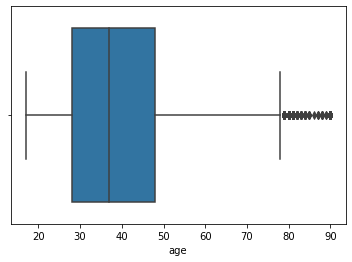

In [75]:
sns.boxplot(x=data['age'])

As you can see, there are a few outlying values. So let us call our function here to get a better estimate about these values and how many are there 

In [76]:
#Passing 0.25 and 0.75 as default values
calcuateIQR(data, 'age',0.25,0.75)

The IQR is 20.0
The lower bound value is -2.0
The upper bound value is 78.0
Total number of outliers are 215


Using the lower bound and upper bound values. I am now going to remove these outliers

In [77]:
age_upper = 78
age_lower = 0

print("Shape before removing outliers for age {}".format(data.shape))
data = data[(data['age'] <= age_upper) & (data['age'] >= age_lower)]
print("Shape after removing outliers for age {}".format(data.shape))
print("A total of 215 were removed")

Shape before removing outliers for age (48789, 14)
Shape after removing outliers for age (48574, 14)
A total of 215 were removed


Let us now again plot the graph to see how the age looks now

<AxesSubplot:xlabel='age'>

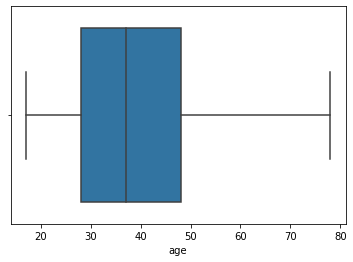

In [78]:
sns.boxplot(x=data['age'])

##### HOURS PER WEEK

<AxesSubplot:xlabel='hours_per_week'>

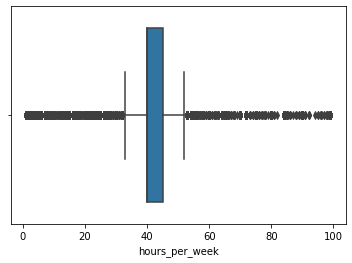

In [79]:
sns.boxplot(x=data['hours_per_week'])

In [80]:
# Passing 0.25 and 0.75 as the default values
calcuateIQR(data, 'hours_per_week',0.25,0.75)

The IQR is 5.0
The lower bound value is 32.5
The upper bound value is 52.5
Total number of outliers are 13350


We can see that there a lot of outliers if we are looking at 25 and 75 Quartile range. And with a feature like hours per week. It is very much possible that there are certain job that dont require a lot of hours but pay you very well. 
Similary there might be a lot of cases of working a lot og hours but getting a lot of salary
So we cannot driectly remove all these values. So to get a much better idea of the distribution. I will plot a age vs hours_per_week plot

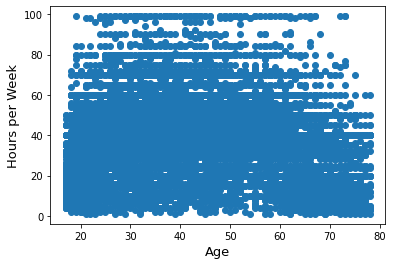

In [81]:
fig, ax = plt.subplots()
ax.scatter(x = data['age'], y = data['hours_per_week'])
plt.ylabel('Hours per Week', fontsize=13)
plt.xlabel('Age', fontsize=13)
plt.show()

As expected this gives us a much better idea of the hours_per_week as i think we cannot treat a student who is 22 year old working 100 hours a week as at such an age there is a lot of energy and it is possible to do it. And as we keep increasing the age we can see that the hours_per_week is generally decreasing which is understanable.

So as a result of these observations, I wont be treating hours_per_week as an outlier and will now check for a different variable

<AxesSubplot:xlabel='education-num'>

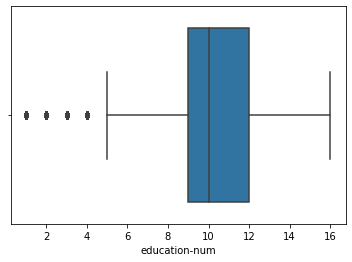

In [82]:
sns.boxplot(x=data['education-num'])

In [83]:
calcuateIQR(data, 'education-num',0.25,0.75)

The IQR is 3.0
The lower bound value is 4.5
The upper bound value is 16.5
Total number of outliers are 1747


Here this shows us that the lower bound is 4.5 but before just removing these values. Let us compare the population with salary and thier education number

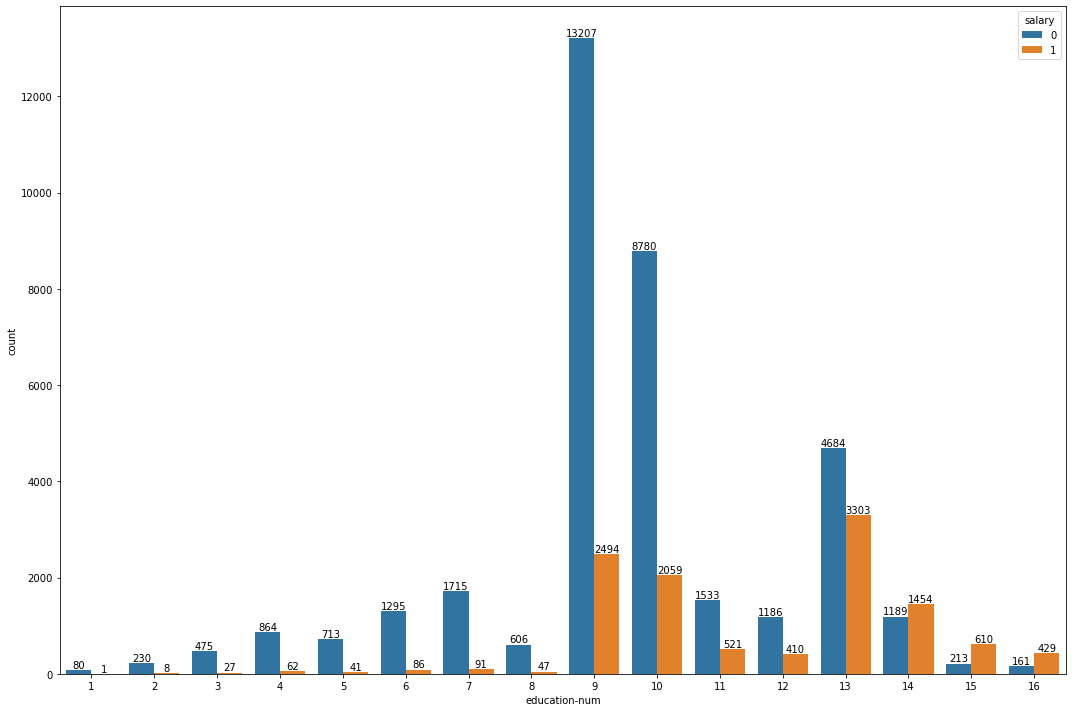

In [84]:
fig = plt.figure(figsize=(15,10))
ax=sns.countplot("education-num", hue='salary', data=data)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

This gives us a much more accurate representation of how the education is distributed. Again looking at these values it is almost guranteed that for education level less than 4 the chances of getting salary greater than 50000 will be really less. But this plot also shows us that how education is realted to salary. My key takeaways from this plot are:
   1. With increase in education level, the chances of getting salary greater than 50000 increases. If you look at education level 13 and beyond. Those bar plot are dominated by salary greater than 50000. So it is clear that salary is dependent upon education numner
   2. One more thing to notice is that if there are really few records below education level 4. So removing these values might help our model to perform better as for these education levels. It is almost certain that the salary will be less than 50000. So the cases with salary greater than 50000 can be treated as outliers

In [85]:
education_upper = 16
education_lower = 3

print("Shape before removing outliers for age {}".format(data.shape))
data = data[(data['education-num'] <= education_upper) & (data['education-num'] >= education_lower)]
print("Shape after removing outliers for age {}".format(data.shape))

Shape before removing outliers for age (48574, 14)
Shape after removing outliers for age (48255, 14)


##### OCCUPATION

<AxesSubplot:xlabel='occupation'>

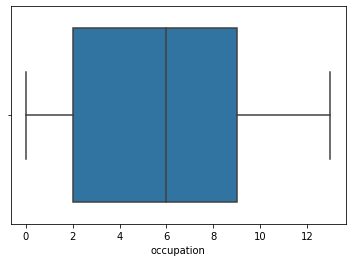

In [86]:
sns.boxplot(x=data['occupation'])

This looks perfectly fine as there are no outliers so we dont have to dig much deeper into this

##### WORKCLASS

<AxesSubplot:xlabel='workclass'>

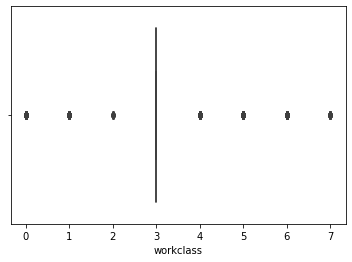

In [87]:
sns.boxplot(x=data['workclass'])

This seems to have a few outliers. Let us look into it in detail. First I will plot a graph to see how the workclass relates to salary

In [88]:
calcuateIQR(data, 'workclass',0.25,0.75)

The IQR is 0.0
The lower bound value is 3.0
The upper bound value is 3.0
Total number of outliers are 12030


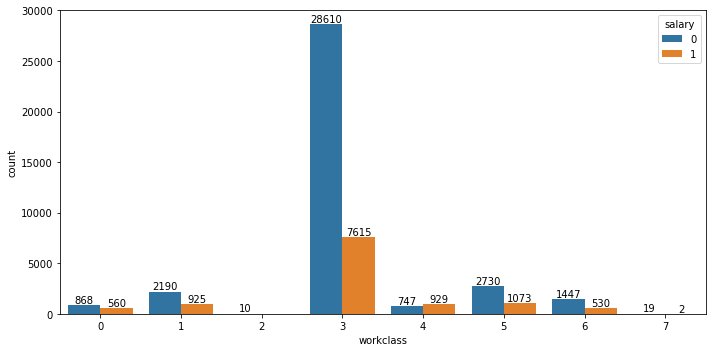

In [89]:
fig = plt.figure(figsize=(10,5))
ax=sns.countplot('workclass', hue='salary', data=data)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

In [90]:
data['workclass'].unique()

array([5, 3, 6, 0, 1, 4, 7, 2])

So for a few workclasses it there are not a lot of working indiduvals working and that means that chances of salary less than or equal to 50000 are very high so keeping these values might lead to overfitting. 
So we have to remove these values. But before that let us see what these workclasses really are.

In [91]:
print(dictWorkclass[2])
print(dictWorkclass[7])

Never-worked
Without-pay


Well these lables explain very clearly that why there are such less values in these. So I think we should remove these values. 
But removing these values using the IQR would not be a wise decision as it will only keep workclass 3. So we will manually filter our database such that these values are no longer there

In [92]:
data['workclass'].replace(2,nan,inplace=True)
data['workclass'].replace(7,nan,inplace=True)
data=data.dropna()

##### MARTIAL STATUS

<AxesSubplot:xlabel='martial_status'>

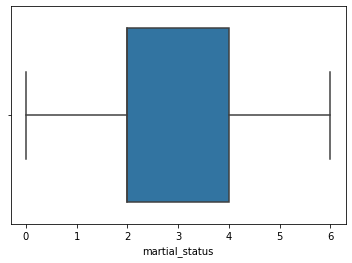

In [93]:
sns.boxplot(x=data['martial_status'])

This looks perfectly fine as there are no outliers

##### SEX

Since it is binary value so there wont be any outliers. But still it is important to undetstand that how salary is distributed amongst the gender. And if there is any role of Gender in Salary

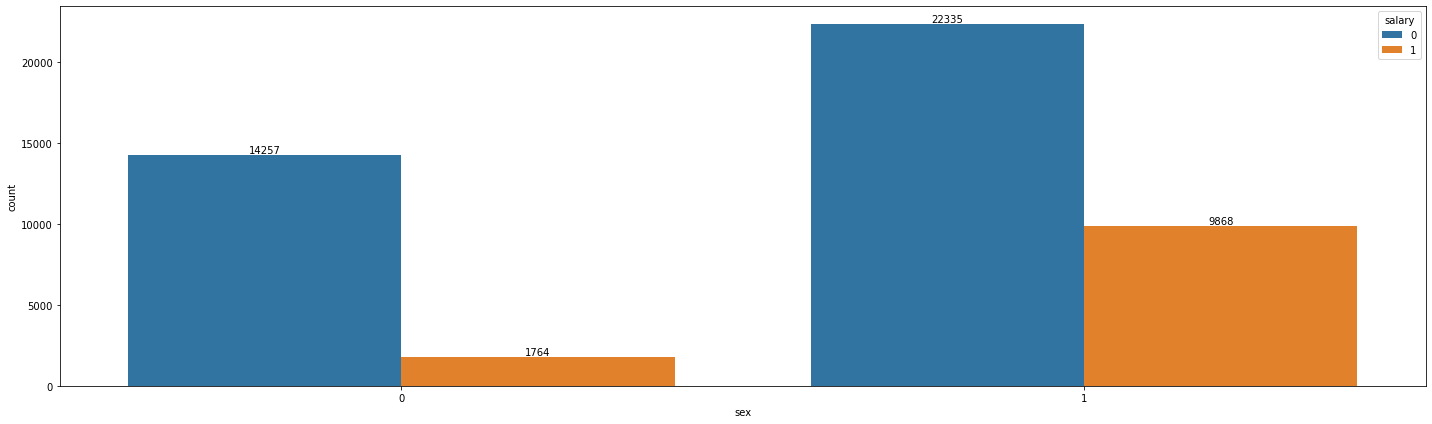

In [94]:
fig = plt.figure(figsize=(20,6))

ax= sns.countplot('sex', hue='salary', data=data)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

Well unexpectdly there seems to be a massive difference between the salaries for Males and Females. One might argue that the working females are much less than that of males. But even if we double the values for Females, it would still be less than that of males for greater than 50000

Let us see that is there any role of education in determining the salary for males and females

##### For Males + Females

<AxesSubplot:xlabel='education-num', ylabel='age'>

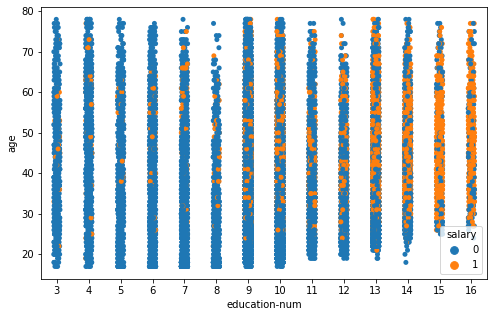

In [95]:
rcParams['figure.figsize'] = (8, 5)
sns.stripplot(data['education-num'],data['age'],hue=data['salary'],data=data)

This is giving us much deep understanding of at a different age, a different education number is realted to salary. As already discussed above, salary is realted to education number. So as we keep increasing the education the salary greater than 50000 are increasing more and more.

Now let us see how this plot looks if we only look at one gender at a time

In [96]:
dictSex

{1: 'Male', 0: 'Female'}


##### For Males

<AxesSubplot:xlabel='education-num', ylabel='age'>

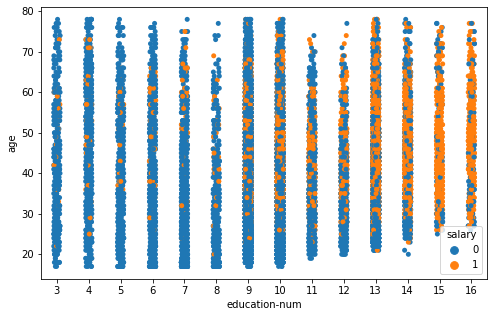

In [97]:
dataMales = data[data['sex']==1]
sns.stripplot(dataMales['education-num'],dataMales['age'],hue=dataMales['salary'],data=dataMales)

As exptected the trend is same. Increase in education is leading to increase in number of salaries greater than 50000.

Let us see if the same trend is observed in case of females as well

##### For Females

<AxesSubplot:xlabel='education-num', ylabel='age'>

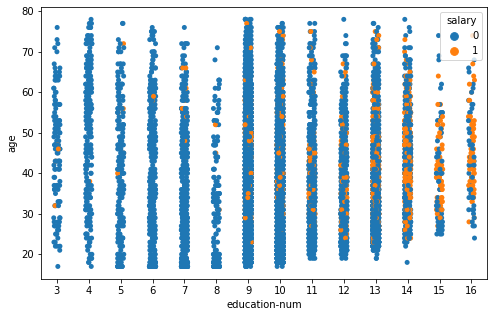

In [98]:
dataFemale = data[data['sex']==0]
sns.stripplot(dataFemale['education-num'],dataFemale['age'],hue=dataFemale['salary'],data=dataFemale)

Now that is a worrying trend, as you can see that females at same age as a male, with a same education number as a male are getting less than 50000 a lot more than that of a male. For example if you look at education level 13 for Male and Female. YOu will see that the number of orange points in females are much less than the number of orange plots in males. Which clearly shows that Gender has some relation with Salary. 

##### But can this be realted to hours_per_week? Maybe thw hours per week for different genders is different, thereby the difference is salaries. Let us plot a similar chart for salary, hours_per_week and educatuion-num and see if there is any trend 

##### Males

<AxesSubplot:xlabel='education-num', ylabel='hours_per_week'>

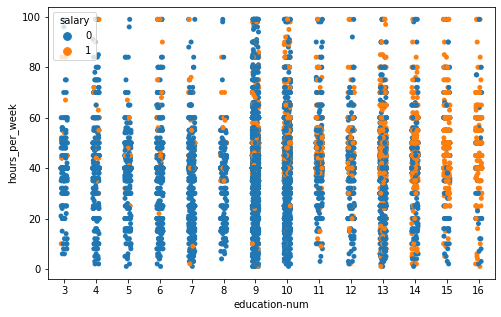

In [99]:
sns.stripplot(dataMales['education-num'],dataMales['hours_per_week'],hue=dataMales['salary'],data=dataMales)

##### FEMALES

<AxesSubplot:xlabel='education-num', ylabel='hours_per_week'>

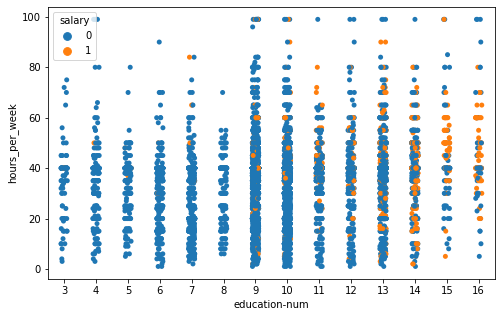

In [100]:
sns.stripplot(dataFemale['education-num'],dataFemale['hours_per_week'],hue=dataFemale['salary'],data=dataFemale)

It seems like for a female who is at a same education level as a male, working same hours per week as a male is getting less salary than a male. This clearly shows that there is some correaltion between the salary and the gender. 

##### NATIVE COUNTRY

<AxesSubplot:xlabel='native_country'>

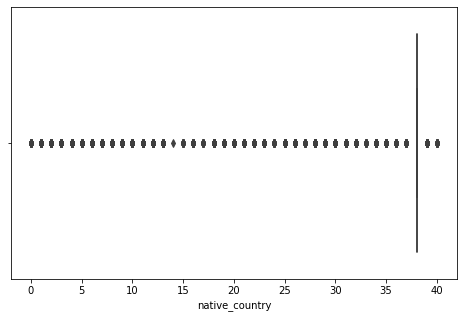

In [101]:
sns.boxplot(x=data['native_country'])

Now this looks a little bit out of place so lets call our calcuate IQR function to look a little bit more into it

In [102]:
calcuateIQR(data, 'native_country',0.25,0.75)

The IQR is 0.0
The lower bound value is 38.0
The upper bound value is 38.0
Total number of outliers are 3894


According to this it seems like the distribution is dominated by just 1 value and which is 38. 

This is where our label and numeric value dictonary will help us
Let us see which is the country represented by 38

In [103]:
print(dictNativeCountry[38])

United-States


So it looks like the feature native country has majority of its values as United States. Let us see how these different values compare against Salaries

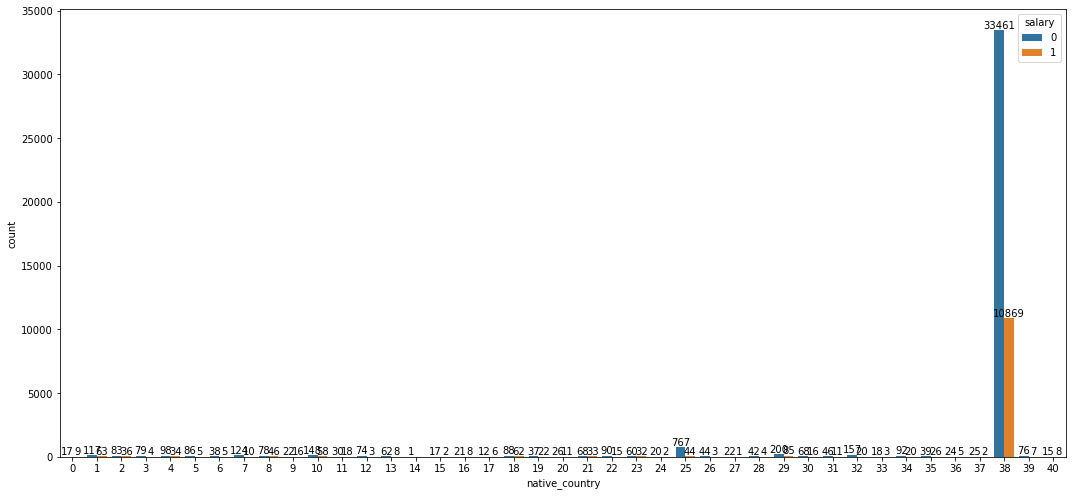

In [104]:
fig = plt.figure(figsize=(15,7))
ax=sns.countplot('native_country', hue='salary', data=data)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

This helps us a lot to see that why this needs to be looked at. I think our model will thrive if we only provide it with a native country US but the performance will be affected if we encounter a different native country.

So till now we havent been able to conculde what to do with the native_country column as dropping the remaning values might lead to signficantly restriciting the accuracy and not removing the outliers will also create an issue as accuracy for those predictions would be really less.

So let us plot a correlation heat plot to see that is there any correaltion between native_country and salary or not so that we can decidewhat to do next.

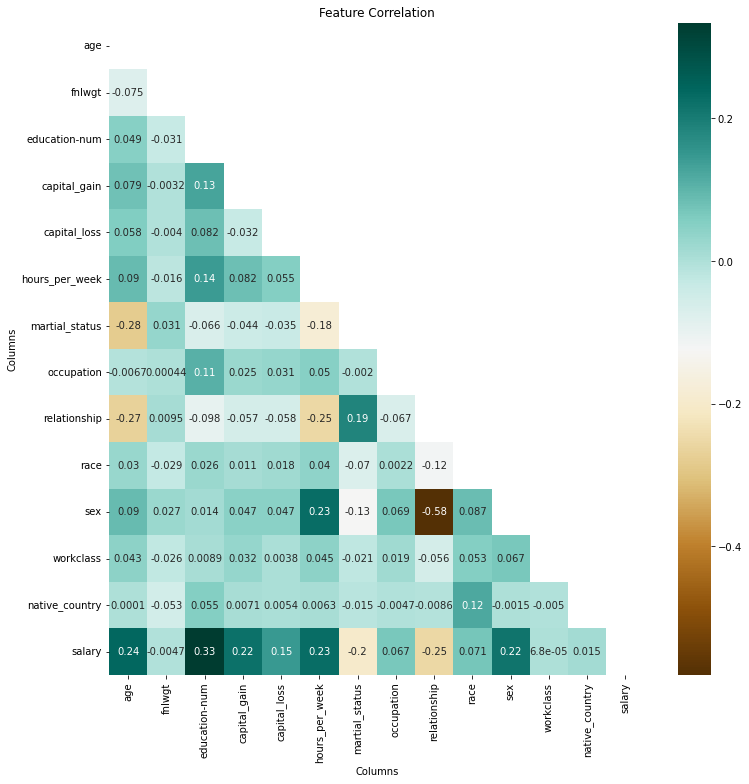

In [105]:
corr_matrix = data.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

fig, ax = plt.subplots(figsize=(12,12)) 

sns.heatmap(corr_matrix, 
            annot=True, 
            mask=mask,
            ax=ax, 
            cmap='BrBG').set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')

ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

As expected, we got to see in a very clear basis how are data is correalted with salary. Lets look at each of the features in deatail
   1. Salay and Age: As exptected there is some correaltion as with age comes experience and it is a vital aspect in determining salary
   2. Salary and fnlwgt: Fnlwgt is the total count of population which is believed to be in a particular category and that has no correaltion with Salary
   3. Salary and Education-num: As visualized before, there is a direct correlation between the two
   4. Salary and Capital Gain: There is some correaltion between Salary and Capital Gain.
   5. Salary and Capital Loss: There is some correaltion between Salary and Capital Loss.
   6. Salary and Hours Per Week: As expected Salary and Hours per week are correalted.
   7. Salary and Martial Status: There is no correaltion between these two. 
   8. Salary and Occupation: There is little ccorrealtion between these as different types of jobs might pay different salaries 
   9. Salary and Relationship: There is no correaltion between these two
   10. Salary and Race: There is little correaltion between these two as well.
   11. Salary and Sex: As explained above, there seems to be correaltion between these two
   12. Salary and Workclass: There seems to be close to 0 correaltion between these two
   13. Salary and Native Country: As expteced hardly these two are correalted 

One more thing to observe from this plot is the problem of Multicollinearity. Let us dig deep into it and see with VIF Test how much multicollinearity is there and then we will proceed accordingly

#### There is really high Multicollinearity between some of our independent variables. Taking all these variables into consideration for our model might give us really good accuracy but the results wont be reliable because of Multicollinearity. Let us look into detail and handle this problem of Multicollinearity before moving on to the model building

So before we decide which features to use in our model, we need to do a VIF Tests and see the VIF values and according to that I will decide which features to keep and which not to keep in our final model

In [106]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data.drop('salary',axis=1)  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data.sort_values(by=['VIF']))

           feature        VIF
3     capital_gain   1.044992
4     capital_loss   1.062278
8     relationship   2.670616
7       occupation   3.095263
1           fnlwgt   4.049236
6   martial_status   4.103215
10             sex   4.455675
11       workclass   8.416249
0              age   9.217713
5   hours_per_week  12.144235
2    education-num  16.792015
9             race  18.107344
12  native_country  29.074718


In [107]:
X = data.drop(['salary','native_country','race','martial_status','age','hours_per_week','fnlwgt'],axis=1)  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data.sort_values(by=['VIF']))

         feature       VIF
1   capital_gain  1.036817
2   capital_loss  1.059554
4   relationship  2.216598
3     occupation  3.038648
5            sex  3.773560
6      workclass  6.945024
0  education-num  9.038736


So based on our observations above, I will decide which features to consider for our KNN Model and which ones to drop. 

In [108]:
features=['capital_gain','capital_loss','relationship','occupation','sex','workclass','education-num']
target=['salary']

## Modelling using KNN (Euclidean Distance)
#### Now we will train a classifier that will train our dataset and will predict salary of any particular set of features that may come in our way

To do this we will use K-Nearest Neighbor classifier. This can be used for Classification and regression.
Here we will use it for Classifiaction. 

#### Create Test Train Split

In [109]:
X = data[features]
y = data[target]

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### How sensitive is k-NN classification accuracy to the choice of the 'k' parameter?

The main question while using k-nn is what should be the value of K. The best methof to do so is hit and trial. But it will take a lot of time. 

So here I will plot a graph to see the best possible value of K in range of 50. Using bigger values than 50 might lead in performace issue as the dataset is large. So till 50 for the value of K which will give us the best accracy score will be the one we will use.

Max accuracy is 0.8602355673523556 for k equals to 15


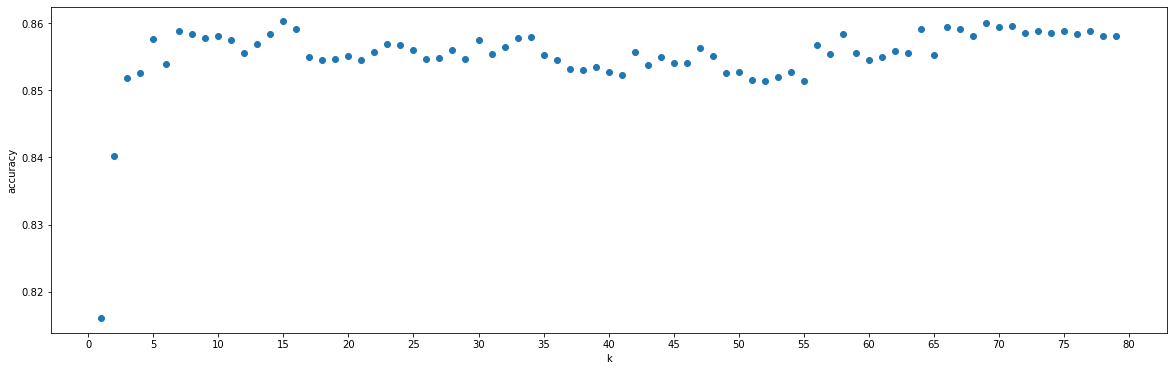

In [110]:
k_range = range(1,80)
scores = []
maxScore=0
kValue=0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    score=knn.score(X_test, y_test)
    scores.append(score)
    if maxScore< score:
        maxScore=score
        kValue=k

plt.figure(figsize=(20,6))
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80])
print("Max accuracy is {} for k equals to {}".format(maxScore,kValue))

As we can see that for K=1 the accuracy is least as it will only check for 1 nearest neighbour. But as we keep increasing the value of K, we can see that the accuracy increases.

There are some alternate behaviors till k=15, but from then onwards the accuracy is gradually decresing. So we are going to use K=15 for our classfication of Salary

Similarly, we will plot a graph to check how the split between test and traning data affects the accuracy score. The one with most accuracy will be the one we will use to split our final data.

### How sensitive is k-NN classification accuracy to the train/test split proportion?

Max accuracy is 85.95 and it is obtained at train/test split of 60.0 %


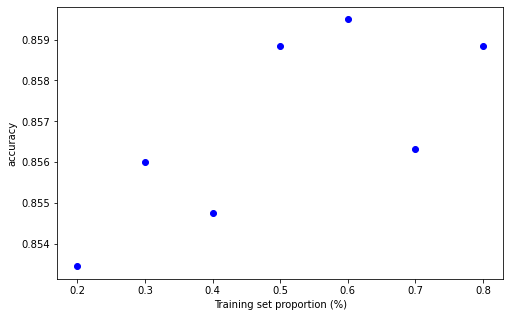

In [111]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 15)
maxAccuracy=0
maxSplit=0

plt.figure()
for s in t:
    scores = []
    for i in range(1,10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    meanScores=np.mean(scores)
    plt.plot(s, meanScores, 'bo')
    if meanScores>maxAccuracy:
        maxAccuracy=meanScores
        maxSplit=s
        
plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy')
print("Max accuracy is {} and it is obtained at train/test split of {} %".format(round(maxAccuracy*100,2),maxSplit*100))

Here we can see that the train/test split also has an effect on the accuracy, till now we were using 75% default split.
But as we can see from the plot here, using a split of 80% will increase the accuracy slightly. 

So now we will use 0.8 test/train split and k=15 for best possible accuracy.

#### Create Test Train Split

In [112]:
X = data[features]
y = data[target]

# We will split 80%, 20% for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.2)

#### Create classifier object

As observed from our previous plots, we will use K=15 as it has maximum accuracy

In [117]:
knn_model = KNeighborsClassifier(n_neighbors = 15)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
cnf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
cnf_matrix_knn

array([[6899,  411],
       [ 937, 1398]], dtype=int64)

In [119]:
KNNScore =knn_model.score(X_test, y_test)
KNNPrecision=precision_score(y_test,y_pred_knn)
KNNRecall=recall_score(y_test,y_pred_knn)
KNNF1Score=f1_score(y_test,y_pred_knn)
print("Accuracy of KNN Model is {} ".format(round(KNNScore,3)))
print("Precison of KNN Model is {} ".format(round(KNNPrecision,3)))
print("Recall of KNN Model is {} ".format(round(KNNRecall,3)))
print("F1Score of KNN Model is {} ".format(round(KNNF1Score,3)))

Accuracy of KNN Model is 0.86 
Precison of KNN Model is 0.773 
Recall of KNN Model is 0.599 
F1Score of KNN Model is 0.675 


#### KNN Feature Importance
#### Shap Feature Explanation
Since the test size is 9000 approximately and producing SHAP values for 9000 records will take a lot of time. So I will take a subset of 1000 predictions and will plot the feature importance based on that subset. 

##### Produce the SHAP values

In [121]:
X_testSubset=X_test.iloc[:100]
knn_explainer = shap.KernelExplainer(knn.predict,X_testSubset)
knn_shap_values = knn_explainer.shap_values(X_testSubset)

  0%|          | 0/100 [00:00<?, ?it/s]

##### The Summary Plot

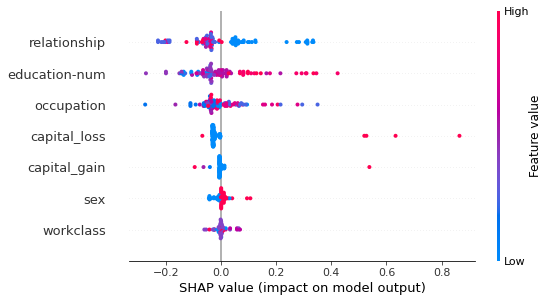

In [126]:
shap.summary_plot(knn_shap_values, X_testSubset)

As expected from our analysis and our visualizations. The features which have a very big say in our target variable 'Salary' are education number, age and hours per week.
One thing that suprises me from this is the sex. Because according to this plot. It does not have a big role to play in salary determination but still the salaries for Males and Females for same features is different. 
So this anomaly is something to report to the stakeholders to look into and make sure that this is removed

##### The Dependence Plot

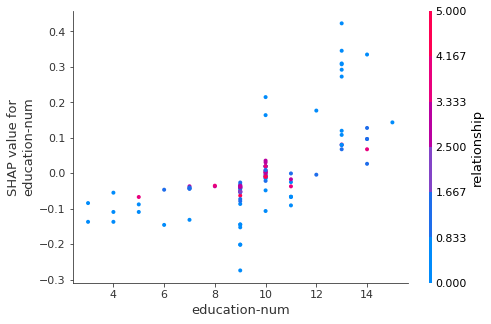

In [123]:
shap.dependence_plot("education-num", knn_shap_values, X_testSubset)

This plot shows us how the feature education-num and age are linearly realted to our target variable 'salary'. A postive change in both is leading to postive shap value 

##### The Individual Force Plot

In [124]:
# Plot the SHAP values for the 99th observation 
shap.force_plot(knn_explainer.expected_value,knn_shap_values[99,:], X_testSubset.iloc[99,:])

For the 99th Record, the predicted value is 0, which means that salary is less than 50K. 

##### The Collective Force Plot

In [125]:
shap.force_plot(knn_explainer.expected_value, knn_shap_values, X_testSubset)

## CONCLUSION

##### DATA ANALYSIS
Based on my data analysis here are a few conclusion I would like to make:
   1. Only about 1/3 of the population at the time would be considered high income while 2/3 of the population was making less than 50,000 USD per year. 
   2. Education was a pretty good indicator of income with the highest percentage of high income individuals finishing a pHD, Masters, or Bachelor's degree. The majority of the population had either a high school degree and / or some college finished.
   3. I discovered a lot of unknown hidden patterns in data which are a really big contributors in determing the salary of an indiduval. Just by looking at the columns of the dataset it could have been easily interpreted that columns like education, age and number of working hours per week would be a big factor in the Salary. But I still went ahead with some analysis and confirmed that these statements were true. 
   4. The male working market was more than doubled the female working market 
   5. But during the analysis I also encountered some other features as well which were realted to Salary. Like Sex, for different sex the salary was different and even in cases where the education levels were same, number of working hours per week were same, the salary distribition was different for males and females. This was a trend which was not expected. 
   6. Also Capital Gain was a good indicator of wealth with a pretty clear separation of people making higher than 50k with higher capital gain which is an indicator of the wealth gap in the US starting to grow.
   7. Capital Loss was a mixture of both high income and low income individuals and not a clear indicator of wealth.


##### KNN AND FEATURE IMPORTANCE
Once we built are KNN model we achieved an accurcy of 85% in predicting the salary classifications based on other features. Choosing the value of K is a big factor in determing how well our model will perform and i choose the best value of K by plotting an accuracy plot of for each value of K from 1-50 and used K=41 for our final modelling which had the best accuracy.


We later also plotted a few visualizations we analysed how each of our independent feature is related to Target. A positive SHAP indicated a positive contribution to the target and negative predicted how that particular feature made a negtive contribution to our target. And for most of our features for our top 1000 predictions the SHAP values were balanced an indicated both Positive and Negative Contribution in different scenarios. 

#### Now we will use our analysis, feature importance and modelling to convey all this data to Stakeholders and policy makers to help them understand how these attributes and decide the salary and how can we improve policies in US which determine the affluency. 
